In [135]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from sklearn.datasets import load_files
import sklearn.naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import scipy


def highest_coefficents(N, feature_names):
    for i, category in enumerate(nyt.target_names):
        idx = np.argsort(clfNB.feature_log_prob_[i])
        print "The most likely {0} words to appear in a document of class {1} are:".format(N, category)
        print 'Probabilities', np.exp(clfNB.feature_log_prob_[2][idx][::-1][:10])
        feature_names[idx][::-1][:10]


def calc_discrimination_metric(target_class, dataset, classifier):
    ckd_range = range(len(dataset.target_names))
    ckd_range.remove(target_class)
    feature_prob_ = np.exp(classifier.feature_log_prob_)
    discrimination_metric = sum(np.abs(feature_prob_[target_class, :] - feature_prob_[ckd_range, :]), 0)
    discrimination_metric = discrimination_metric/len(ckd_range)
    discrimination_metric_signed = sum(feature_prob_[target_class, :] - feature_prob_[ckd_range, :], 0)
    discrimination_metric_signed = discrimination_metric_signed/len(ckd_range)
    return discrimination_metric, discrimination_metric_signed


def most_discriminating_words(N, feature_names, clf):
    with open("./results/most_discriminating_words.json", "w") as outfile:
        results = {}
        for i, category in enumerate(nyt.target_names):
            discrimination_metric, discrimination_metric_signed = calc_discrimination_metric(i, nyt, clf)
            idx = np.argsort(discrimination_metric)
            words = feature_names[idx][::-1][:N]
            probs = discrimination_metric_signed[idx][::-1][:N]
            results[category] = zip(words, probs)
            print "The most discrminating %d words for class %s are:" % (N, category)
            print words
            print "They have probabilities:"
            print probs
        json.dump(results, outfile, indent=4)


def calculate_cv_confusion_matrix(y_true, y_pred, target_names):
    cm_norm = np.zeros([len(target_names), len(target_names)])
    cm = confusion_matrix(y_true, y_pred)
    cm_norm[:, :] = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)

    print('Confusion matrix, with normalisation')
    print(cm_norm)
    plt.figure()
    plot_confusion_matrix(cm_norm, target_names)


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
#     plt.savefig('./results/' + title.lower().replace(" ", "_") + ".png", transparant=True)
#     plt.close()


def get_predictions(kfold, clf, doc_term_matrix, y):
    y_pred = []
    y_test = []
    clf_score = []
    for train, test in kfold:
        clf.fit(doc_term_matrix[train, :], y[train])
        clf_score.append(clf.score(doc_term_matrix[test, :], y[test]))
        y_pred.append(clf.fit(doc_term_matrix[train, :], y[train]).predict(doc_term_matrix[test, :]))
        y_test.append(y[test])
    return y_pred, y_test, clf_score

In [264]:
nyt = load_files(os.environ["data_dir"] + "/nyt_corpus/txt_document/", shuffle=True)
kfold = cross_validation.KFold(n=len(nyt.data), n_folds=3)
clfNB = sklearn.naive_bayes.BernoulliNB()
# Tokenize
count_vect = CountVectorizer(decode_error='ignore', ngram_range=(1, 1))
doc_term_matrix = count_vect.fit_transform(nyt.data)
feature_names = np.array(count_vect.get_feature_names())
X = np.array(nyt.data)
y = np.array(nyt.target)

In [253]:
doc_term_matrix.shape

(5050, 84641)

In [254]:
doc_term_matrix

<5050x84641 sparse matrix of type '<type 'numpy.int64'>'
	with 1326758 stored elements in Compressed Sparse Row format>

In [255]:
X_train, X_test, y_train, y_test = train_test_split(doc_term_matrix, y, test_size=0.2, random_state=42)

## Bernoulli Classification

In [213]:
parameters = {'alpha': np.linspace(0,1,10)}
clfBernoulliNB = sklearn.naive_bayes.BernoulliNB()
clfBNB = GridSearchCV(clfBernoulliNB, parameters)

In [214]:
clfBNB.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.     ,  0.11111,  0.22222,  0.33333,  0.44444,  0.55556,
        0.66667,  0.77778,  0.88889,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [215]:
print clfBNB.best_params_
print clfBNB.best_score_

{'alpha': 0.1111111111111111}
0.890099009901


In [91]:
scores = np.array([i[1] for i in clf.grid_scores_])
std_error = np.array([scipy.std(i[2]) for i in clf.grid_scores_])
alphas = [i[0]['alpha'] for i in clf.grid_scores_] 

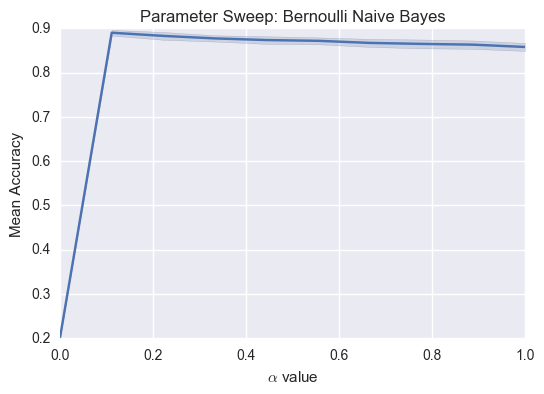

In [102]:
plt.plot(alphas, scores)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Parameter Sweep: Bernoulli Naive Bayes")
plt.xlabel(r"$\alpha$ value")
plt.ylabel("Mean Accuracy")

## Multinomial Naive Bayes Classification

In [256]:
parameters = {'alpha': np.linspace(0,1,10)}
clfMultinomialNB = sklearn.naive_bayes.MultinomialNB()
clfMNB = GridSearchCV(clfMultinomialNB, parameters)

In [257]:
clfMNB.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.     ,  0.11111,  0.22222,  0.33333,  0.44444,  0.55556,
        0.66667,  0.77778,  0.88889,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [258]:
print clfMNB.best_params_
print clfMNB.best_score_

{'alpha': 0.44444444444444442}
0.930445544554


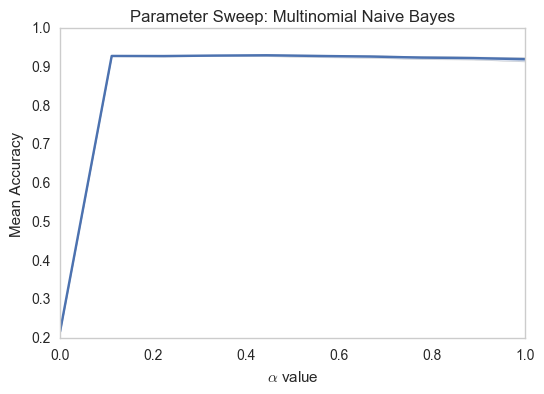

In [259]:
scores = np.array([i[1] for i in clfMNB.grid_scores_])
std_error = np.array([scipy.std(i[2]) for i in clfMNB.grid_scores_])
alphas = [i[0]['alpha'] for i in clfMNB.grid_scores_] 

plt.plot(alphas, scores)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
plt.title("Parameter Sweep: Multinomial Naive Bayes")
plt.xlabel(r"$\alpha$ value")
plt.ylabel("Mean Accuracy")

## Score out of time sample

In [260]:
from sklearn.metrics import accuracy_score

0.939603960396
Confusion matrix, with normalisation
[[ 0.85  0.    0.13  0.    0.03]
 [ 0.01  0.96  0.01  0.01  0.02]
 [ 0.01  0.    0.94  0.02  0.01]
 [ 0.    0.    0.01  0.97  0.02]
 [ 0.    0.    0.    0.    0.98]]


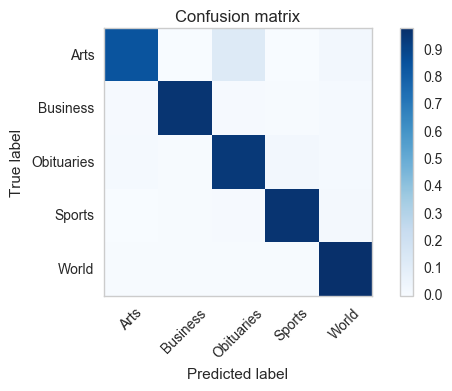

In [261]:
y_pred =  clfMNB.best_estimator_.predict(X_test)
print accuracy_score(y_test, y_pred)
calculate_cv_confusion_matrix(y_test, y_pred, nyt.target_names)

0.886138613861
Confusion matrix, with normalisation
[[ 0.81  0.01  0.16  0.01  0.02]
 [ 0.02  0.96  0.01  0.    0.02]
 [ 0.02  0.    0.94  0.02  0.01]
 [ 0.01  0.01  0.08  0.86  0.03]
 [ 0.01  0.04  0.09  0.    0.86]]


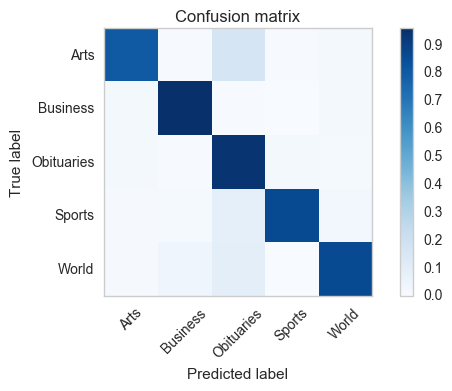

In [223]:
y_pred =  clfBNB.best_estimator_.predict(X_test)
print accuracy_score(y_test, y_pred)
calculate_cv_confusion_matrix(y_test, y_pred, nyt.target_names)

## Find the most discriminating words

In [262]:
def calc_discrimination_metric(target_class, dataset, classifier):
    ckd_range = range(len(dataset.target_names))
    ckd_range.remove(target_class)
    feature_prob_ = np.exp(classifier.feature_log_prob_)
    print feature_prob_.mean(), feature_prob_.max()
    discrimination_metric = sum(np.abs(feature_prob_[target_class, :] - feature_prob_[ckd_range, :]), 0)
    discrimination_metric = discrimination_metric/len(ckd_range)
    discrimination_metric_signed = sum(feature_prob_[target_class, :] - feature_prob_[ckd_range, :], 0)
    discrimination_metric_signed = discrimination_metric_signed/len(ckd_range)
    return feature_prob_, discrimination_metric, discrimination_metric_signed


def most_discriminating_words(N, feature_names, clf):
    with open("./results/most_discriminating_words.json", "w") as outfile:
        results = {}
        for i, category in enumerate(nyt.target_names):
            feature_prob_, discrimination_metric, discrimination_metric_signed = calc_discrimination_metric(i, nyt, clf)
            idx = np.argsort(discrimination_metric)
            print idx
            words = feature_names[idx][::-1][:N]
            probs = discrimination_metric_signed[idx][::-1][:N]
            results[category] = zip(words, probs)
            print "The most discrminating %d words for class %s are:" % (N, category)
            print words
            print "They have probabilities:"
            print probs
        json.dump(results, outfile, indent=4)
    return feature_prob_

In [263]:
# get most discriminating ngrams for each category
feature_prob_ = most_discriminating_words(10, feature_names, clfMNB.best_estimator_)

1.1814605215e-05 0.0180466624632
[ 6036 42621  7388 ...,  6829 50477 65644]
The most discrminating 10 words for class Arts are:
[u'said' u'mr' u'art' u'street' u'music' u'212' u'museum' u'new' u'org'
 u'ms']
They have probabilities:
[-0.01 -0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
1.1814605215e-05 0.0180466624632
[11215  5811 48906 ..., 65644  8611 17257]
The most discrminating 10 words for class Business are:
[u'company' u'bank' u'said' u'mr' u'percent' u'billion' u'financial'
 u'million' u'firm' u'chief']
They have probabilities:
[ 0.01  0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
1.1814605215e-05 0.0180466624632
[  872 48499 41900 ..., 22340 65644 50477]
The most discrminating 10 words for class Obituaries are:
[u'mr' u'said' u'died' u'york' u'dr' u'born' u'game' u'company'
 u'university' u'ms']
They have probabilities:
[ 0.01 -0.01  0.    0.    0.    0.   -0.   -0.    0.    0.  ]
1.1814605215e-05 0.0180466624632
[50474 41576 41562 ..., 65644 30975 50477]
The 

In [197]:
np.sort(np.abs(feature_prob_[0] - feature_prob_[1:5]).sum(axis=0))

array([  4.13e-07,   4.13e-07,   4.13e-07, ...,   2.22e-02,   2.58e-02,
         2.76e-02])

In [140]:
discrimination_metric, discrimination_metric_signed = calc_discrimination_metric(0, nyt, clf.best_estimator_)

In [143]:
discrimination_metric

array([  1.03e-07,   1.03e-07,   1.03e-07, ...,   5.55e-03,   6.46e-03,
         6.90e-03])

In [142]:
discrimination_metric.sort()

## For multinomial NB

In [234]:
X_train[y_train==0].shape

(815, 84944)

In [238]:
tf = X_train[y_train==0].sum(axis=0)

In [239]:
N = X_train[y_train==0].sum()

In [242]:
V = X_train.shape[1]

In [248]:
tf.max()

815

In [245]:
np.sort((tf + 0.222)/(N + V*0.222))

matrix([[  5.98e-07,   5.98e-07,   5.98e-07, ...,   2.19e-03,   2.20e-03,
           2.20e-03]])